### Census Data Cleaning


In [15]:
import pandas as pd

# loads the CSV
df = pd.read_csv("W-T2_A24census-7.csv")



### Age cleaning

In [16]:
# counts missing values in each column
df_missing = df.isnull().sum()

# counts number of unique values in each column
df_unique = df.nunique()


print("Missing values per column:")
print(df_missing)
print("Unique values per column:")
print(df_unique)


Missing values per column:
House Number                        0
Street                              0
First Name                          0
Surname                             0
Age                                 0
Relationship to Head of House     714
Marital Status                   2193
Gender                              0
Occupation                          0
Infirmity                        9465
Religion                         5428
dtype: int64
Unique values per column:
House Number                      245
Street                            104
First Name                        366
Surname                           691
Age                               117
Relationship to Head of House      20
Marital Status                      8
Gender                              9
Occupation                       1107
Infirmity                           7
Religion                           13
dtype: int64


In [17]:
# to clean column names
df.columns = df.columns.str.strip()

In [28]:
df['Age'].unique()

<IntegerArray>
[  52,   59,   14,   13,   41,   43,   12,   76,   78,   48,
 ...
  105,   94,  102,  104,  108,   90, <NA>,  107,   98,   97]
Length: 108, dtype: Int64

In [26]:
# converts Age to numeric and converts decimals to whole values
df['Age'] = pd.to_numeric(df['Age'], errors='coerce').round().astype('Int64')

# checks invalid ages therefore non convertible entries become nan
print(df[df['Age'].isna()])


     House Number            Street First Name Surname   Age  \
4410            2  Collins Mountain      Harry  Winter  <NA>   
6487          227      White Branch      Reece   Riley  <NA>   

     Relationship to Head of House Marital Status Gender         Occupation  \
4410                          Head         SINGLE   Male  building surveyor   
6487                           Son            NaN   Male              child   

     Infirmity     Religion Occupation Grouped  
4410       NaN    Christian  Building Surveyor  
6487       NaN  No Religion         Unemployed  


### Religion cleaning

In [31]:
df['Religion'].unique()

array(['No Religion', 'Christian', 'Muslim', 'Jewish', 'Sikh', 'Other'],
      dtype=object)

In [23]:
# cleans religion values
df['Religion'] = df['Religion'].str.strip().str.title()
df['Religion'] = df['Religion'].fillna('No Religion')

# normalize odd entries
df['Religion'] = df['Religion'].replace({
    'Methodist': 'Christian',
    'Catholic': 'Christian',
    'Orthodoxy': 'Christian',
    'None': 'No Religion',
    'Nope': 'No Religion',
    'Undecided': 'No Religion',
    'Jedi': 'Not Stated',
    'Housekeeper': 'Not Stated',
})


# to get the most common religion per street ignoring not stated
street_defaults = (
    df[df['Religion'] != 'Not Stated']
    .groupby('Street')['Religion']
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

# fills in Not stated using the most common religion on that street
df['Religion'] = df.apply(
    lambda row: street_defaults.get(row['Street'], 'No Religion')
    if row['Religion'] == 'Not Stated' else row['Religion'],
    axis=1
)

# group rare or unclear ones under Other or No Religion
df['Religion'] = df['Religion'].replace({
    'Agnostic': 'Other Religions',
    'Pagan': 'Other Religions',
    'Not Stated': 'No Religion',
})


print(" Religion categories after cleaning:")
print(df['Religion'].value_counts())


 Religion categories after cleaning:
Religion
No Religion        5434
Christian          3889
Muslim              124
Sikh                 56
Jewish               37
Other Religions       3
Name: count, dtype: int64


### Occupation cleaning

In [33]:
df['Occupation'].unique()

array(['microbiologist', 'homeopath', 'student', ...,
       'retired contractor',
       'retired emergency planning/management officer',
       'retired psychologist, prison and probation services'],
      dtype=object)

In [24]:
# clean up occupation names lowercase and remove extra spaces
df['Occupation'] = df['Occupation'].str.lower().str.strip()

# groups jobless labels under 'Unemployed'
unemployed_terms = ['none', 'unemployed', 'n/a', 'na', 'unknown', 'child']
df['Occupation Grouped'] = df['Occupation'].apply(
    lambda x: 'Unemployed' if any(term in x for term in unemployed_terms) else x.title()
)

# combines all student types into 'Student'
student_variants = {
    'Student': 'Student',
    'University Student': 'Student',
    'Phd Student': 'Student',
}
df['Occupation Grouped'] = df['Occupation Grouped'].replace(student_variants)

# fixes odd formatting 
df['Occupation Grouped'] = df['Occupation Grouped'].replace({
    'Engineer, Chemical': 'Chemical Engineer'
})


print(" Top 10 Occupations (after grouping):")
print(df['Occupation Grouped'].value_counts().head(10))



 Top 10 Occupations (after grouping):
Occupation Grouped
Student                    2484
Unemployed                 2130
Chemical Engineer            29
Licensed Conveyancer         19
Electrical Engineer          18
Petroleum Engineer           17
Clinical Cytogeneticist      17
Field Trials Officer         16
Production Engineer          16
Tourism Officer              15
Name: count, dtype: int64


### Cleaning Marital status

In [34]:
df['Marital Status'].unique()

array(['Married', 'N/A', 'Widowed', 'Single', 'Divorced', nan],
      dtype=object)

In [28]:
# to clean up text
df['Marital Status'] = df['Marital Status'].str.strip().str.upper()

# to replace codes with full labels
status_map = {
    'S': 'Single',
    'M': 'Married',
    'D': 'Divorced',
    'W': 'Widowed',
    'N/A': 'N/A'
}
df['Marital Status'] = df['Marital Status'].replace(status_map)

# fill in missing status as 'N/A' for anyone under 18
df['Marital Status'] = df.apply(
    lambda row: 'N/A' if pd.isnull(row['Marital Status']) and (row['Age'] is not pd.NA and row['Age'] < 18) else row['Marital Status'],
    axis=1

)


df['Marital Status'] = df['Marital Status'].str.title()


print("Marital Status distribution after cleaning:")
print(df['Marital Status'].value_counts(dropna=False))



Marital Status distribution after cleaning:
Marital Status
Single      3456
Married     2574
N/A         2192
Divorced     910
Widowed      410
NaN            1
Name: count, dtype: int64


### Infirmity

In [35]:
df['Infirmity'].unique()

array([nan, 'Mental Disability', 'Physical Disability',
       'Unknown Infection', ' ', 'Blind', 'Deaf', 'Disabled'],
      dtype=object)

In [36]:
df['Relationship to Head of House'].unique()

array(['Head', 'Husband', 'Son', 'Daughter', 'Visitor', 'Wife', 'Cousin',
       nan, 'Partner', 'Granddaughter', 'Lodger', 'Nephew', 'Sibling',
       'Niece', 'Grandson'], dtype=object)

In [29]:
# clean up typo errors and group similar relationships
df['Relationship to Head of House'] = df['Relationship to Head of House'].replace({
    'Neice': 'Niece',
    'None': 'Unspecified',
    'Step-Son': 'Son',
    'Adopted Son': 'Son',
    'Step-Daughter': 'Daughter',
    'Adopted Daughter': 'Daughter',
    'Adopted Grandson': 'Grandson',
    'Adopted Granddaughter': 'Granddaughter'
})

# view cleaned values
print("Relationship to Head of House (cleaned):")
print(df['Relationship to Head of House'].value_counts())


Relationship to Head of House (cleaned):
Relationship to Head of House
Head             3342
Son              1647
Daughter         1602
Husband           949
Lodger            421
Wife              333
Partner           242
Granddaughter      85
Grandson           81
Sibling            51
Cousin             32
Visitor            28
Nephew              9
Niece               7
Name: count, dtype: int64


### Gender cleaning

In [41]:
df['Gender'].unique()

array(['Female', 'Male', ' '], dtype=object)

In [30]:
# Standardize gender entries
gender_map = {
    'm': 'Male', 'male': 'Male',
    'f': 'Female', 'female': 'Female'
}

df['Gender'] = df['Gender'].replace(' ', pd.NA)
df['Gender'] = (
    df['Gender']
    .str.strip().str.lower()
    .map(gender_map)
    .fillna(df['Gender'])
)


# Show results
print(" Gender distribution after cleaning:")
print(df['Gender'].value_counts(dropna=False))



 Gender distribution after cleaning:
Gender
Female    4980
Male      4562
<NA>         1
Name: count, dtype: int64


### Household ID cleaning

In [40]:
df['Household ID'].unique()

array(['1 Scott Forks', '2 Scott Forks', '3 Scott Forks', ...,
       '1 Guardian Obervatory', '1 Young Bastion', '1 Baker Rocks'],
      dtype=object)

In [31]:
# Build a unique household ID from house number + street name
df['Household ID'] = df['House Number'].astype(str) + ' ' + df['Street']

# Count how many people live in each household
household_sizes = df.groupby('Household ID').size()

# Show a quick summary of household sizes
print("Household Size Summary:")
print(household_sizes.describe())




Household Size Summary:
count    3332.000000
mean        2.864046
std         2.119474
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        22.000000
dtype: float64


In [7]:
# compute dependency ratios
# defines working age (15–64), children (<15) and elderly (65 and above)
df['AgeGroup'] = pd.cut(df['Age'], bins=[0,15,65,120], labels=['child','working','elderly'])
counts = df['AgeGroup'].value_counts()

child = counts['child']
elderly = counts['elderly']
working = counts['working']

child_dep_ratio = child / working * 100
old_dep_ratio   = elderly / working * 100

print(f"Child Dependency Ratio: {child_dep_ratio:.1f}%")
print(f"Old-Age Dependency Ratio: {old_dep_ratio:.1f}%")


Child Dependency Ratio: 27.2%
Old-Age Dependency Ratio: 14.2%


In [11]:
age_unemp = df.groupby('AgeGroup').apply(
    lambda x: (x['Occupation']=='Unemployed').mean() * 100
)
print(age_unemp)

AgeGroup
child      0.000000
working    8.105279
elderly    4.626709
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_112140\519241513.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_unemp = df.groupby('AgeGroup').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_112140\519241513.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_unemp = df.groupby('AgeGroup').apply(


### Remaining missing values

In [32]:
# remaining missing values
print("Remaining missing values:")
print(df.isnull().sum())


Remaining missing values:
House Number                        0
Street                              0
First Name                          0
Surname                             0
Age                                 2
Relationship to Head of House     714
Marital Status                      1
Gender                              1
Occupation                          0
Infirmity                        9465
Religion                            0
Occupation Grouped                  0
Household ID                        0
dtype: int64


### Visualizations

C:\Users\user\AppData\Local\Temp\ipykernel_112140\1270441318.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pyramid = df.groupby(['AgeGroup', 'Gender']).size().unstack(fill_value=0)


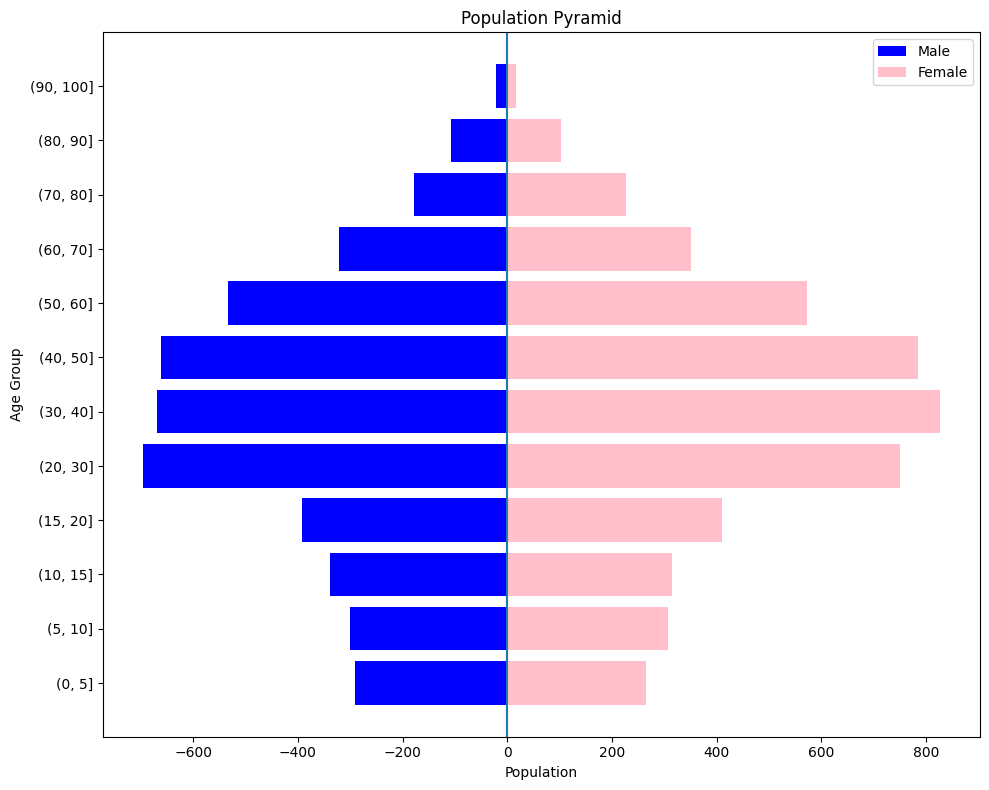

In [33]:
# creating bins for ages
bins = [0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df['AgeGroup'] = pd.cut(df['Age'], bins)

# data grouping
pyramid = df.groupby(['AgeGroup', 'Gender']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 8))

# male-left
ax.barh(pyramid.index.astype(str), -pyramid['Male'], color='blue', label='Male')
# female-right
ax.barh(pyramid.index.astype(str), pyramid['Female'], color='pink', label='Female')

ax.set_xlabel('Population')
ax.set_ylabel('Age Group')
ax.set_title('Population Pyramid')
ax.legend()

plt.axvline(0)
plt.tight_layout()
plt.show()


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

Matplotlib is building the font cache; this may take a moment.


C:\Program Files\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


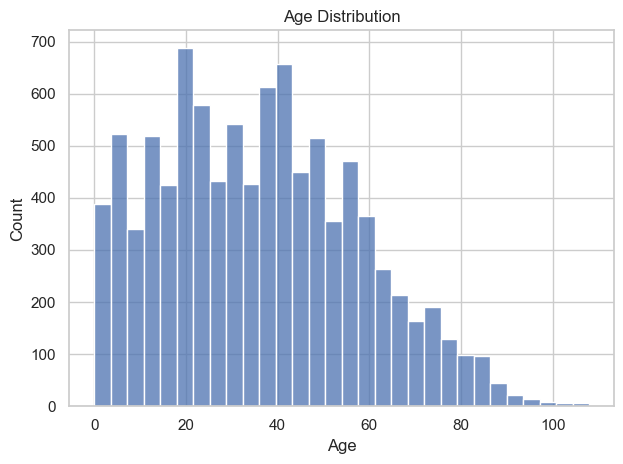

In [57]:
# Age histogram
sns.histplot(df['Age'].dropna(), bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


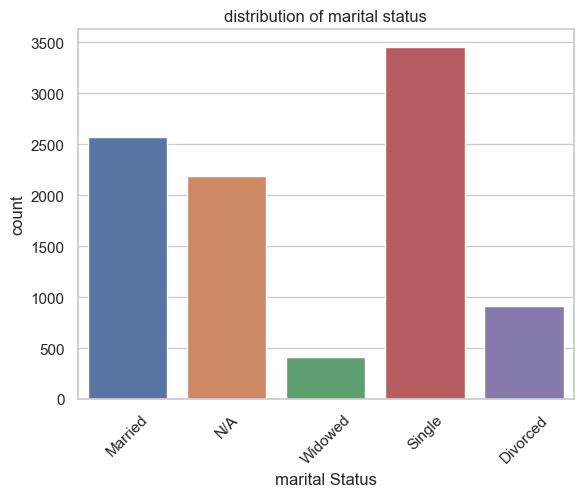

In [58]:

# distribution of marital status
sns.countplot(x=df['Marital Status'])
plt.xticks(rotation=45) 
plt.title("distribution of marital status")
plt.xlabel("marital Status")
plt.ylabel("count")
plt.show()


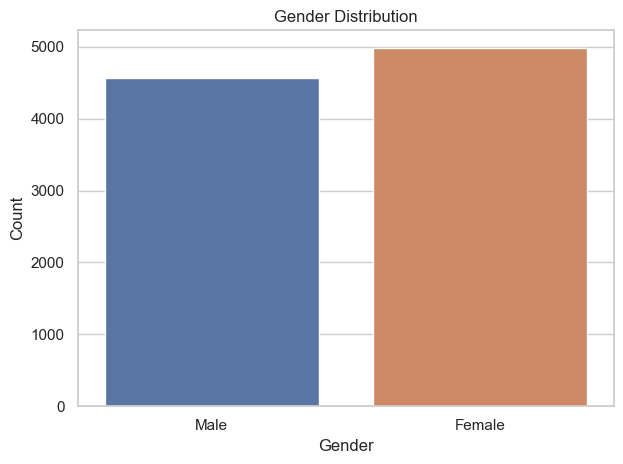

In [59]:
# gender distribution
sns.countplot(data=df, x='Gender', order=['Male', 'Female'])
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

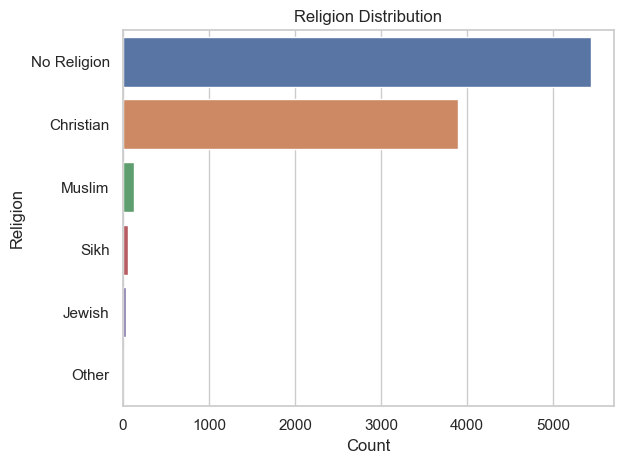

In [39]:
# Religion distribution
sns.countplot(data=df, y='Religion', order=df['Religion'].value_counts().index)
plt.title("Religion Distribution")
plt.xlabel("Count")
plt.ylabel("Religion")
plt.tight_layout()
plt.show()

C:\Program Files\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


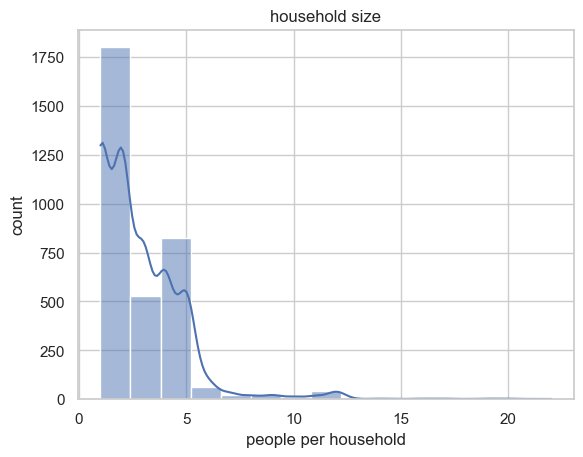

In [61]:
# household distribution
household_sizes = df.groupby(['House Number', 'Street']).size()
sns.histplot(household_sizes, bins=15, kde=True)
plt.title("household size")
plt.xlabel("people per household")
plt.ylabel("count")
plt.show()


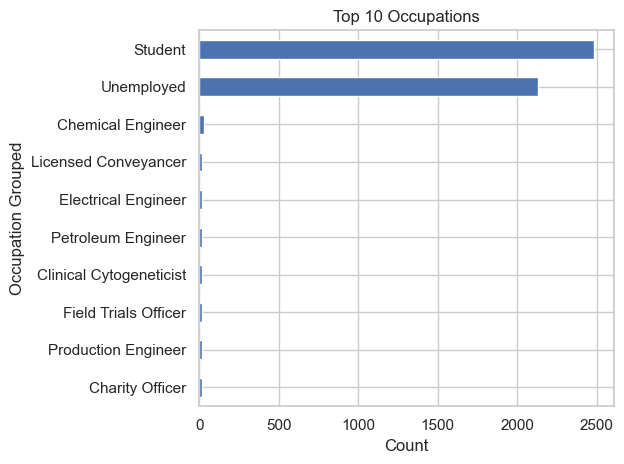

In [62]:
# top 10 occupations
top_jobs = df['Occupation Grouped'].value_counts().head(10)
top_jobs.plot(kind='barh')
plt.title("Top 10 Occupations")
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
